# Analysis-Ready Raster Data cubes

In [1]:
import itertools

import dask
import dask.array
import icechunk as ic
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style="text")

## The GLAD LCLU Dataset



We will use the GLAD Land Cover Land Use dataset from [this URL](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/download.html) for demonstration purposes. The data is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

> Potapov, P., Hansen, M.C., Pickens, A., Hernandez-Serna, A., Tyukavina, A., Turubanova, S., Zalles, V., Li, X., Khan, A., Stolle, F. and Harris, N., 2022. The global 2000-2020 land cover and land use change dataset derived from the Landsat archive: first results. Front. Remote Sens. 3: 856903. doi: 10.3389/frsen. https://doi.org/10.3389/frsen.2022.856903

This is a datacube, distributed as 10° x 10° tiles. We will assemble the full cube and store it as a single array in an Icechunk store.

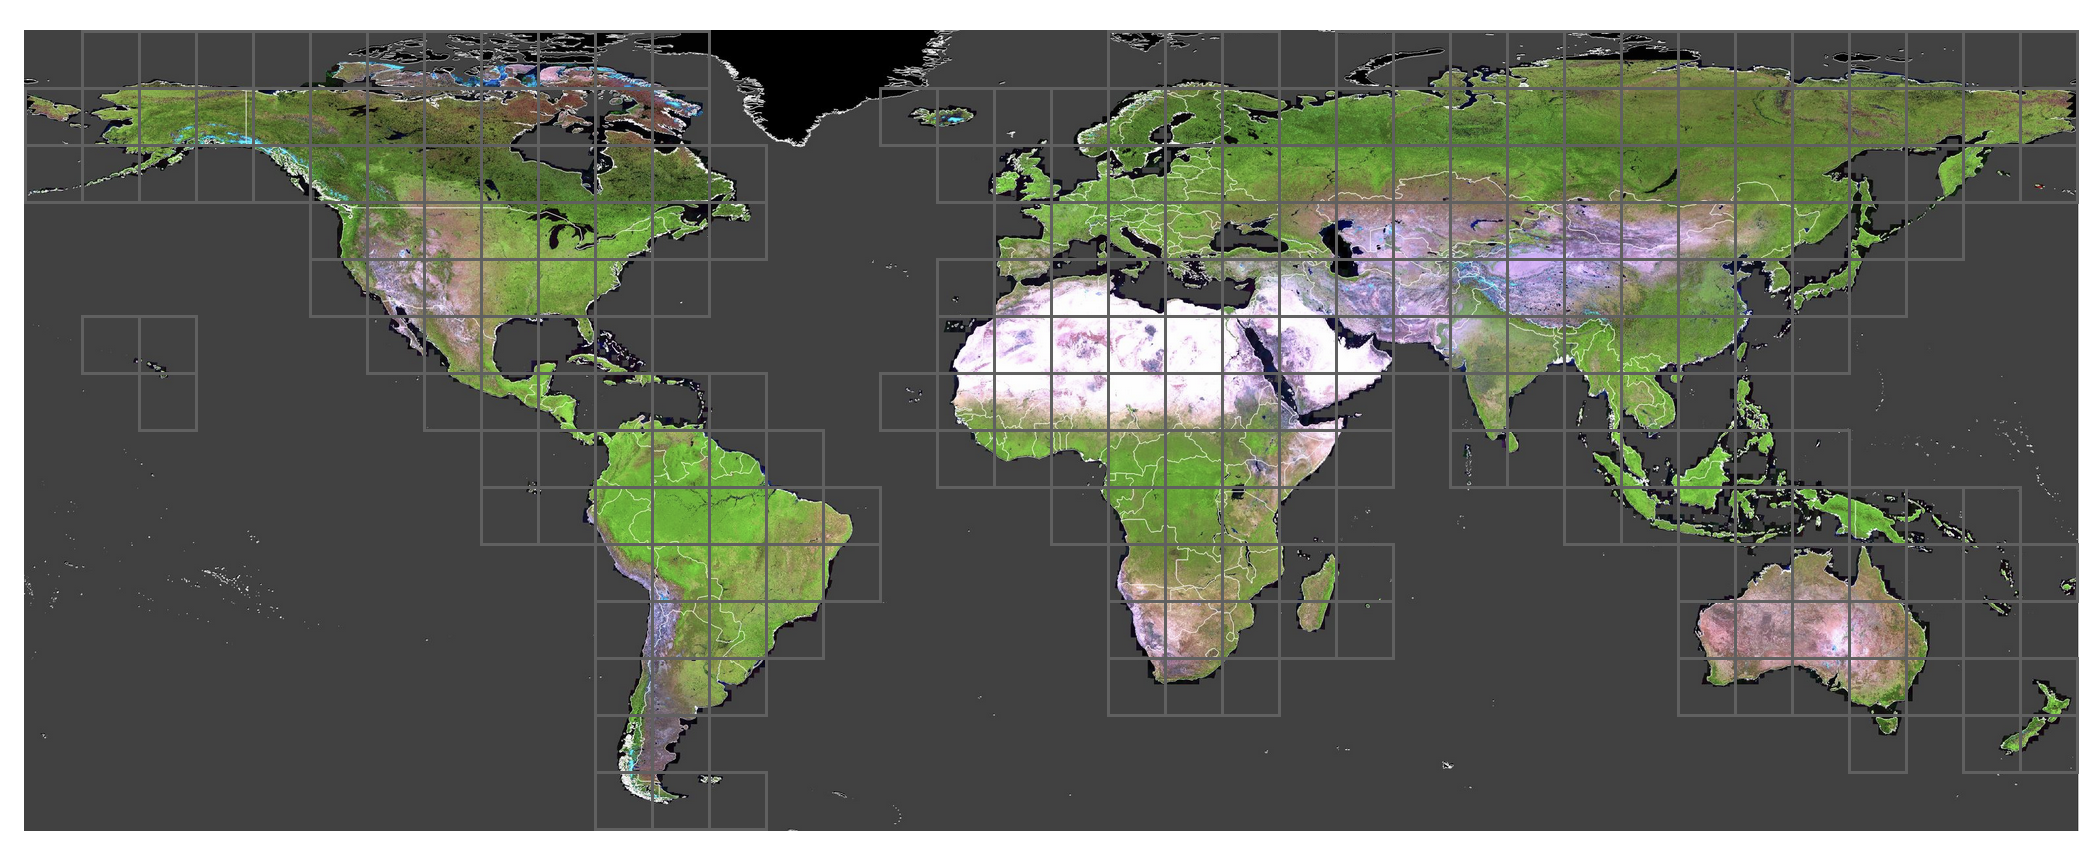


Our approach will be to read all existing tiles, and write them to the appropriate region of the global datacube.

In [2]:
from dataclasses import dataclass

# Define the tiling grid: each tile is 10°x10°, and
# for years 2000, 2005, 2010, 2015, 2020

ROOT_URI = "gs://earthenginepartners-hansen/GLCLU2000-2020/v2"


@dataclass
class TilingGrid:
    tilex = pd.RangeIndex(-180, 180, 10)
    tiley = pd.RangeIndex(80, -60, -10)
    year = pd.RangeIndex(2000, 2021, 5)
    npixels = 40_000  # pixels per dimension per tile

    @property
    def datacube_shape(self) -> tuple[int, int, int]:
        return (
            len(self.year),
            self.npixels * len(self.tiley),
            self.npixels * len(self.tilex),
        )

    def get_region(self, tile) -> dict[str, int]:
        xstart = (self.tilex.get_loc(np.round(tile.rio.bounds()[0], 3))) * self.npixels
        ystart = (self.tiley.get_loc(np.round(tile.rio.bounds()[-1], 3))) * self.npixels
        tstart = self.year.get_loc(tile.year.data.item())
        region = {
            "x": slice(xstart, xstart + tile.sizes["x"]),
            "y": slice(ystart, ystart + tile.sizes["y"]),
            "year": slice(tstart, tstart + 1),
        }
        return region


tiling = TilingGrid()

We must define the chunk size for the final datacube. We will _choose_ (1000 x 1000) spatial chunks.

In [3]:
ZARR_CHUNK_SIZE = (1, 1000, 1000)
DASK_CHUNK_SIZE = (1, 8000, 8000)  # must be a integer multiple of ZARR_CHUNK_SIZE

We will write this to `s3://icechunk-public-data/v1/glad`

In [4]:
storage = ic.s3_storage(
    bucket="icechunk-public-data", prefix="v1/glad", region="us-east-1"
)

## Approach

1. Initialize the Icechunk store with the full cube, but write no data.
2. Incrementally populate the cube with data from each GeoTIFF tile in parallel.

## Initialize the store

### Examine a single tile

First open a single file, this lets us examine extra attributes, data types, etc.

In [5]:
import os

# request GDAL to use unauthenticated access
os.environ["GS_NO_SIGN_REQUEST"] = "1"
ds = xr.open_dataset(
    f"{ROOT_URI}/2000/70N_180W.tif",
    # use rasterio to read the TIFF
    engine="rasterio",
    # By default, xarray will replace NoData values with np.nan. Turn that off.
    mask_and_scale=False,
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:      (band: 1, x: 40000, y: 40000)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 320kB -180.0 -180.0 -180.0 ... -170.0 -170.0 -170.0
  * y            (y) float64 320kB 70.0 70.0 70.0 70.0 ... 60.0 60.0 60.0 60.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) uint8 2GB ...

Now we construct a helper function that renames the variable, and adds useful metadata like the `year`.

In [6]:
def read_tile(
    tile: str, year: int, *, chunks=dict(zip(("band", "y", "x"), DASK_CHUNK_SIZE))
):
    """
    Helper function to read a single tile, specified as a string e.g. '70N_180W'
    for a single year.
    """
    import os

    # unauthenticated access
    os.environ["GS_NO_SIGN_REQUEST"] = "1"

    from rasterio.env import Env

    with Env(GDAL_CACHEMAX=0, VSI_CACHE=False, VSI_CACHE_SIZE=0):
        ds = (
            xr.open_dataset(
                f"{ROOT_URI}/{year}/{tile}.tif",
                engine="rasterio",
                # we must read as dask array so that the expand_dims step is lazy
                chunks=chunks,
                mask_and_scale=False,
                lock=False,
            )
            # Add a nice data variable name
            .rename({"band_data": "lclu"})
            # this is a singleton dimension, drop it
            .squeeze("band", drop=True)
            # add a more useful time dimension
            .expand_dims(year=[year])
        )
    return ds


ds = read_tile(tile="70N_180W", year=2000)
ds

/var/folders/sc/hsdthq2x7mnbfvwnk7rp4xmr0000gn/T/ipykernel_72121/1148752937.py:17: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 8000. This could degrade performance. Instead, consider rechunking after loading.
  xr.open_dataset(


<xarray.Dataset> Size: 2GB
Dimensions:      (year: 1, x: 40000, y: 40000)
Coordinates:
  * year         (year) int64 8B 2000
  * x            (x) float64 320kB -180.0 -180.0 -180.0 ... -170.0 -170.0 -170.0
  * y            (y) float64 320kB 70.0 70.0 70.0 70.0 ... 60.0 60.0 60.0 60.0
    spatial_ref  int64 8B ...
Data variables:
    lclu         (year, y, x) uint8 2GB dask.array<chunksize=(1, 8000, 8000), meta=np.ndarray>

### Create a template for the global datacube

Now create a "template" dataset that represents the full cube. 

The Icechunk store will be initialized with the _structure_ of this dataset, including coordinate labels and metadata but not the actual data values.
1. Since we just need an array of the right shape and data type and the values don't matter, we create a `dask` array of zeros.
2. We assign the `year` coordinate of the right shape.
3. We copy over the `spatial_ref` variable from the tile we opened. It is convention for GDAL to express the affine transformation information as a `GeoTransform` attribute attached to the `spatial_ref` variable. We will rewrite this to be appropriate for the global grid.

Note the chunk size here does not matter; we will explicitly specify the chunking when writing.

In [7]:
template = xr.Dataset(
    {
        "lclu": (
            ("year", "y", "x"),
            dask.array.zeros(tiling.datacube_shape, chunks=-1, dtype=np.uint8),
            {
                "publication": (
                    "Potapov, P., Hansen, M.C., Pickens, A., Hernandez-Serna, A., Tyukavina, A., Turubanova, S., Zalles, V., Li, X., Khan, A., Stolle, F. "
                    "and Harris, N., 2022. The global 2000-2020 land cover and land use change dataset derived from the Landsat archive: first results. "
                    "Front. Remote Sens. 3: 856903."
                ),
                "doi": "10.3389/frsen",
                "grid_mapping": "spatial_ref",
            },
        )
    },
    coords={"year": ("year", tiling.year), "spatial_ref": ds.spatial_ref},
)
# Update the top-left corner information in the GeoTransform
template.spatial_ref.attrs["GeoTransform"] = (
    f"{tiling.tilex[0]:.1f} 0.00025 0.0 {tiling.tiley[0]:.1f} 0.0 -0.00025"
)

template.attrs["license"] = "CC BY 4.0"
template

<xarray.Dataset> Size: 4TB
Dimensions:      (year: 5, y: 560000, x: 1440000)
Coordinates:
    spatial_ref  int64 8B ...
  * year         (year) int64 40B 2000 2005 2010 2015 2020
Dimensions without coordinates: y, x
Data variables:
    lclu         (year, y, x) uint8 4TB dask.array<chunksize=(5, 560000, 1440000), meta=np.ndarray>
Attributes:
    license:  CC BY 4.0

### Initialize the store with the template

In [9]:
import icechunk as ic

repo = ic.Repository.create(storage)

We specify important details about how the `lclu` variable is recorded on disk in the `encoding`. Specifically 
1. we choose a Zarr chunksize of (1, 1000, 1000) which means each chunk has 1000x1000 spatial fooprint for a single year; Importantly this perfectly subdivides each tile which are 40_000 x 40_000.
2. set the `fill_value` to 255. Empty tiles will be filled with this value. This value was chosen from [the legend](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/legend.xlsx) provided with the dataset.

In [10]:
session = repo.writable_session("main")
template.to_zarr(
    session.store,
    compute=False,  # important, don't write data values, just the array metadata!
    mode="w",
    encoding={"lclu": {"chunks": ZARR_CHUNK_SIZE, "fill_value": 255}},
    consolidated=False,
)
session.commit("initialize array")

'VD9R98Q7DC2Y3HYCPXAG'

## Write a single tile

A single tile distributed as a single GeoTIFF corresponds to a contiguous "region" within the full data cube. 
To construct the full datacube, we will

1. read each available tile, and write to the appropriate region of the data cube.
2. need to determine this region using the tiling grid. 
3. use `to_zarr(..., region=...)` to write to that region of the full datacube.

Helpfully, rioxarray provides a `.rio.bounds` method that lets us access the bounding box for the tile.

In [7]:
def update_tile(
    *, session: ic.Session, tiling: TilingGrid, tile: str, year: int
) -> ic.Session:
    """
    Read a single tile, and write it to the appropriate region of the Icechunk store using Zarr.

    Returns the Icechunk session, to allow for coordinated distributed writes. See
    https://icechunk.io/en/latest/parallel/ for more.
    """
    tile = read_tile(tile=tile, year=year, chunks=None)
    tile.drop_vars("spatial_ref").to_zarr(
        session.store,
        region=tiling.get_region(tile),
        consolidated=False,
    )
    return session

We will test it out.

In [9]:
repo = ic.Repository.open(storage)
session = repo.writable_session("main")
update_tile(session=session, tiling=tiling, tile="70N_180W", year=2000)
session.status()

Chunks updated:
    /lclu:
        [0, 40, 0]
        [0, 40, 1]
        [0, 40, 2]
        [0, 40, 3]
        [0, 40, 4]
        [0, 40, 5]
        [0, 40, 6]
        [0, 40, 7]
        [0, 40, 8]
        [0, 40, 9]
        ... 1590 more

At this point, it is a good idea to make sure you've done things currently by examining the data.

## Distribute the writes

Everything up to here is generalizable.

Now to execute the workload we _choose_ to use dask and [Coiled](https://coiled.io). In principle, everything below can be translated to your favorite cloud orchestration platform.

### Set up Coiled

In [27]:
import coiled

# Create software environment
coiled.create_software_environment(
    name="raster-ingest",
    conda={
        "channels": ["conda-forge"],
        "dependencies": [
            "python=3.12",
            "icechunk",
            "xarray",
            "rioxarray",
            "gcsfs",
            "dask",
            "coiled",
        ],
    },
    workspace="earthmover-devs-gcp",
)

{'id': 150770,
 'created': '2025-04-18T21:24:23.652631+00:00',
 'updated': '2025-04-18T21:42:44.269395+00:00',
 'name': 'raster-ingest',
 'spec_count': 3,
 'account_slug': 'earthmover-devs-gcp',
 'latest_spec': {'id': 156151,
  'created': '2025-04-18T21:42:44.265542+00:00',
  'updated': '2025-04-18T21:42:44.280783+00:00',
  'md5': 'e6637b89f1b4f5c6bb8e212dac7c143f',
  'gpu_enabled': False,
  'latest_build': {'id': 145920,
   'created': '2025-04-18T21:42:44.274101+00:00',
   'updated': '2025-04-18T21:43:30.285701+00:00',
   'state': 'built',
   'reason': 'Build finished'},
  'container_uri': None,
  'architecture': 'x86_64'}}

In [28]:
cluster = coiled.Cluster(
    n_workers=[10, 200],
    software="raster-ingest",
    name="write-glad",
    workspace="earthmover-devs-gcp",
    idle_timeout="10m",
)

Output()

2025-04-21 13:52:14,495 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=10 maximum=200


In [29]:
import distributed

client = distributed.Client(cluster)
client

<Client: 'tls://10.0.0.24:8786' processes=7 threads=28, memory=105.18 GiB>

### Set up write tasks

Now that we have our infrastructure, we will generate a single task for each tile.

Helpfully the dataset comes with a text file listing available tiles ([example](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2000.txt)).

Each task will be responsible for reading a single tile with `read_tile` and writing it to the Icechunk store with `update_tile`.

Note that handling writes to Icechunk within a serverless framework requires [some care](https://icechunk.io/en/latest/parallel/).

In [30]:
def get_update_tile_tasks_for_year(year: int):
    """
    The GLAD dataset comes with a text file of available tiles.

    Example: https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2000.txt

    Parse that to construct a number of `update_tile` tasks.
    """
    import dask
    import fsspec

    with fsspec.open(f"{ROOT_URI}/{year}.txt", mode="r") as f:
        return map(
            lambda line: dask.delayed(update_tile)(
                session=session,
                tiling=tiling,
                tile=line.split("/")[-1].removesuffix(".tif"),
                year=year,
            ),
            f.read().splitlines(),
        )

### Execute the writes

In [ ]:
repo = ic.Repository.open(storage)
session = repo.writable_session("main")
with session.allow_pickling():
    tasks = [get_update_tile_tasks_for_year(year) for year in tiling.year]
    tasks = tuple(itertools.chain(*tasks))
    print(f"Issuing {len(tasks)} tasks.")
    sessions = dask.compute(*tasks, scheduler=client)

Issuing 1400 tasks.


### Merge the sessions and commit.

In [ ]:
from icechunk.distributed import merge_sessions

session = merge_sessions(session, *sessions)
session.commit("write GLAD LCLU data")

## Read the dataset back

In [9]:
repo = ic.Repository.open(storage)
list(repo.ancestry(branch="main"))

[SnapshotInfo(id="R0FDCD691X6CG7DXT6P0", parent_id=K91GSYS9M1KY2SS1HSX0, written_at=datetime.datetime(2025,4,21,20,24,56,846660, tzinfo=datetime.timezone.utc), message="wrote coor..."),
 SnapshotInfo(id="K91GSYS9M1KY2SS1HSX0", parent_id=VD9R98Q7DC2Y3HYCPXAG, written_at=datetime.datetime(2025,4,21,20,7,6,737263, tzinfo=datetime.timezone.utc), message="write GLAD..."),
 SnapshotInfo(id="VD9R98Q7DC2Y3HYCPXAG", parent_id=T8RM0DN1QA8ECS49MF7G, written_at=datetime.datetime(2025,4,21,19,44,34,655816, tzinfo=datetime.timezone.utc), message="initialize..."),
 SnapshotInfo(id="T8RM0DN1QA8ECS49MF7G", parent_id=None, written_at=datetime.datetime(2025,4,21,19,44,31,76681, tzinfo=datetime.timezone.utc), message="Repository...")]

In [10]:
ds = xr.open_dataset(
    repo.readonly_session("main").store, engine="zarr", consolidated=False
)
ds

<xarray.Dataset> Size: 4TB
Dimensions:      (y: 560000, year: 5, x: 1440000)
Coordinates:
    spatial_ref  int64 8B ...
  * y            (y) float64 4MB 80.0 80.0 80.0 80.0 ... -60.0 -60.0 -60.0 -60.0
  * year         (year) int64 40B 2000 2005 2010 2015 2020
  * x            (x) float64 12MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    lclu         (year, y, x) uint8 4TB ...
Attributes:
    license:  CC BY 4.0